In [1]:
import os
os.environ['PROJ_LIB'] ='C:/Users/user/anaconda3/envs/fire_multimodal/Library/share/proj'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#os.environ['GDAL_DATA'] = 'C:\\Users\\Sai kiran\\anaconda3\\envs\sai\\Library\\share'

In [2]:
import torch

import pandas as pd
import natsort

# pip install fastai==1.0.61
from fastai.vision import *
from fastai.tabular import *
from fastai.vision import get_transforms
from typing import Tuple

from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *

from pathlib import Path


# use gpu by default if available
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
def crop_image_using_coordinates(InputImage, OutputImage, RefImage, latitude, longitude, InputCrs, OutputCrs, CropSize):
    """extract tiff height and width"""
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)
    width = Image.RasterXSize
    height = Image.RasterYSize
    Image = None

    """extract vertex coordinates"""
    rds = rasterio.open(RefImage)
    rds.bounds
    left = rds.bounds[0]
    right = rds.bounds[2]
    top = rds.bounds[3]
    bottom = rds.bounds[1]

    """Convert coordinates system"""
    resolution_x = (right - left) / width
    resolution_y = (top - bottom) / height

    InputCrs = 'EPSG:4326'
    OutputCrs ='EPSG:4326'
    transformer = Transformer.from_crs(InputCrs, OutputCrs)
    longitude, latitude = transformer.transform(longitude, latitude)
    
    left_box = latitude - (resolution_x * CropSize)
    top_box = longitude + (resolution_y * CropSize)
    right_box = latitude + (resolution_x * CropSize)
    bottom_box = longitude - (resolution_y * CropSize)
    window = (left_box, top_box, right_box, bottom_box)

    gdal.Translate(OutputImage, InputImage, projWin = window)

In [4]:
fire=pd.read_csv("G_fire.csv",encoding='cp949')
nofire=pd.read_csv("G_nofire.csv",encoding='cp949')
fire.head(5)
nofire.head(5)

,field1,i,j,lon,lat,습도,강수,기온,풍속,날씨,특보내용,target
0,20110122,145,313,128.871809,37.786543,40.128791,0.000000,-2.467752,3.945949,없음,없음,1
1,20110201,143,310,128.854779,37.797953,54.952699,0.000000,1.049347,1.936912,없음,없음,1
2,20110226,216,152,127.957879,37.381517,23.066370,0.000000,13.431703,1.434781,없음,없음,1
3,20110212,244,139,127.884083,37.221789,46.988972,0.012152,-6.417820,1.834428,없음,없음,1
4,20110211,147,183,128.133853,37.775134,56.415674,0.000000,1.448924,2.580111,없음,없음,1


,field1,i,j,lon,lat,습도,강수,기온,풍속,날씨,특보내용,target
0,20160721,129,160,128.003291,37.877817,65.721596,0.0,24.389631,1.453097,0,없음,0
1,20160601,165,102,127.674049,37.672451,51.780365,0.0,18.521161,1.774259,0,없음,0
2,20140221,219,323,128.928575,37.364403,64.609462,0.0,1.351082,1.637306,0,없음,0
3,20180210,160,151,127.952202,37.700974,73.634628,0.0,-3.365851,0.432005,0,없음,0
4,20110219,140,137,127.872730,37.815066,80.610205,0.0,-5.039165,0.413060,0,없음,0


In [5]:
# 행 방향으로 데이터프레임 연결
data = pd.concat([fire, nofire])
data=data.reset_index(drop=True)
data
data.to_csv('data.csv',encoding='cp949')

,field1,i,j,lon,lat,습도,강수,기온,풍속,날씨,특보내용,target
0,20110122,145,313,128.871809,37.786543,40.128791,0.000000,-2.467752,3.945949,없음,없음,1
1,20110201,143,310,128.854779,37.797953,54.952699,0.000000,1.049347,1.936912,없음,없음,1
2,20110226,216,152,127.957879,37.381517,23.066370,0.000000,13.431703,1.434781,없음,없음,1
3,20110212,244,139,127.884083,37.221789,46.988972,0.012152,-6.417820,1.834428,없음,없음,1
4,20110211,147,183,128.133853,37.775134,56.415674,0.000000,1.448924,2.580111,없음,없음,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2140,20211115,128,146,127.923819,37.883521,94.053007,0.000000,2.146356,0.277835,0,없음,0
2141,20190217,112,100,127.662696,37.974795,85.655821,0.000000,-8.746485,0.525876,0,없음,0
2142,20140217,84,124,127.798934,38.134524,63.784203,0.000000,1.323292,2.931593,0,없음,0
2143,20140225,89,109,127.713785,38.106001,90.089028,0.000000,-1.105872,0.578714,0,없음,0


In [6]:
# InputImage = 'forestmap.tif'
# RefImage = 'gw_boundary.tif'
# for i in tqdm(range(len(data))):
#     OutputImage = f'forestmap/forestmap{i}.tif'
#     lon=data['lon'][i]
#     lat=data['lat'][i]
#     crop_image_using_coordinates(InputImage, OutputImage, RefImage, lon, lat, '4326', '4326', 25)

In [7]:
data

,field1,i,j,lon,lat,습도,강수,기온,풍속,날씨,특보내용,target
0,20110122,145,313,128.871809,37.786543,40.128791,0.000000,-2.467752,3.945949,없음,없음,1
1,20110201,143,310,128.854779,37.797953,54.952699,0.000000,1.049347,1.936912,없음,없음,1
2,20110226,216,152,127.957879,37.381517,23.066370,0.000000,13.431703,1.434781,없음,없음,1
3,20110212,244,139,127.884083,37.221789,46.988972,0.012152,-6.417820,1.834428,없음,없음,1
4,20110211,147,183,128.133853,37.775134,56.415674,0.000000,1.448924,2.580111,없음,없음,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2140,20211115,128,146,127.923819,37.883521,94.053007,0.000000,2.146356,0.277835,0,없음,0
2141,20190217,112,100,127.662696,37.974795,85.655821,0.000000,-8.746485,0.525876,0,없음,0
2142,20140217,84,124,127.798934,38.134524,63.784203,0.000000,1.323292,2.931593,0,없음,0
2143,20140225,89,109,127.713785,38.106001,90.089028,0.000000,-1.105872,0.578714,0,없음,0


In [8]:
data['ndvi_img']=["NDVI/"+i[:-4] for i in natsort.natsorted(os.listdir('tif_data/NDVI'))]
data['slope_img']=["경사도/"+i[:-4] for i in natsort.natsorted(os.listdir('tif_data/경사도'))]
data['alt_img']=["고도/"+i[:-4] for i in natsort.natsorted(os.listdir('tif_data/고도'))]
data['forest_img']=["임상도/"+i[:-4] for i in natsort.natsorted(os.listdir('tif_data/임상도'))]
data.head(7)

,field1,i,j,lon,lat,습도,강수,기온,풍속,날씨,특보내용,target,ndvi_img,slope_img,alt_img,forest_img
0,20110122,145,313,128.871809,37.786543,40.128791,0.000000,-2.467752,3.945949,없음,없음,1,NDVI/Crop_NDVI_0,경사도/Crop_Slope_0,고도/Crop_Height_0,임상도/Crop_임상도_0
1,20110201,143,310,128.854779,37.797953,54.952699,0.000000,1.049347,1.936912,없음,없음,1,NDVI/Crop_NDVI_1,경사도/Crop_Slope_1,고도/Crop_Height_1,임상도/Crop_임상도_1
2,20110226,216,152,127.957879,37.381517,23.066370,0.000000,13.431703,1.434781,없음,없음,1,NDVI/Crop_NDVI_2,경사도/Crop_Slope_2,고도/Crop_Height_2,임상도/Crop_임상도_2
3,20110212,244,139,127.884083,37.221789,46.988972,0.012152,-6.417820,1.834428,없음,없음,1,NDVI/Crop_NDVI_3,경사도/Crop_Slope_3,고도/Crop_Height_3,임상도/Crop_임상도_3
4,20110211,147,183,128.133853,37.775134,56.415674,0.000000,1.448924,2.580111,없음,없음,1,NDVI/Crop_NDVI_4,경사도/Crop_Slope_4,고도/Crop_Height_4,임상도/Crop_임상도_4
5,20110131,117,285,128.712864,37.946272,34.354605,0.000000,-1.117193,4.893022,없음,없음,1,NDVI/Crop_NDVI_5,경사도/Crop_Slope_5,고도/Crop_Height_5,임상도/Crop_임상도_5
6,20110309,255,250,128.514184,37.159038,19.754238,0.000000,3.165503,4.683941,없음,없음,1,NDVI/Crop_NDVI_6,경사도/Crop_Slope_6,고도/Crop_Height_6,임상도/Crop_임상도_6


In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.3, stratify=data['target'], random_state=533)
print(len(train_df), len(test_df))

1501 644


In [10]:
train_df.head()
test_df.head()

,field1,i,j,lon,lat,습도,강수,기온,풍속,날씨,특보내용,target,ndvi_img,slope_img,alt_img,forest_img
1220,20200203,153,80,127.549164,37.740907,30.374581,0.0,0.305662,2.174182,0,없음,0,NDVI/Crop_NDVI_1220,경사도/Crop_Slope_1220,고도/Crop_Height_1220,임상도/Crop_임상도_1220
1157,20121120,166,102,127.674049,37.666747,32.606663,0.0,6.442705,1.957580,0,없음,0,NDVI/Crop_NDVI_1157,경사도/Crop_Slope_1157,고도/Crop_Height_1157,임상도/Crop_임상도_1157
1984,20200210,71,210,128.287120,38.208683,68.753980,0.0,-0.886233,0.714077,0,없음,0,NDVI/Crop_NDVI_1984,경사도/Crop_Slope_1984,고도/Crop_Height_1984,임상도/Crop_임상도_1984
988,20210427,80,181,128.122500,38.157342,78.712959,0.0,10.673287,0.265497,없음,없음,1,NDVI/Crop_NDVI_988,경사도/Crop_Slope_988,고도/Crop_Height_988,임상도/Crop_임상도_988
713,20180207,149,322,128.922898,37.763725,23.328898,0.0,-4.093802,3.202910,없음,없음,1,NDVI/Crop_NDVI_713,경사도/Crop_Slope_713,고도/Crop_Height_713,임상도/Crop_임상도_713


,field1,i,j,lon,lat,습도,강수,기온,풍속,날씨,특보내용,target,ndvi_img,slope_img,alt_img,forest_img
1196,20200816,168,144,127.912466,37.655338,97.914671,0.0,24.451841,0.378805,0,없음,0,NDVI/Crop_NDVI_1196,경사도/Crop_Slope_1196,고도/Crop_Height_1196,임상도/Crop_임상도_1196
1331,20161123,153,159,127.997615,37.740907,51.003735,0.0,-0.972612,0.752917,0,없음,0,NDVI/Crop_NDVI_1331,경사도/Crop_Slope_1331,고도/Crop_Height_1331,임상도/Crop_임상도_1331
938,20200224,159,101,127.668373,37.706679,49.483924,0.0,7.869296,1.325086,없음,없음,1,NDVI/Crop_NDVI_938,경사도/Crop_Slope_938,고도/Crop_Height_938,임상도/Crop_임상도_938
1340,20150205,200,335,128.996694,37.472791,58.631221,0.0,1.387238,2.472989,0,없음,0,NDVI/Crop_NDVI_1340,경사도/Crop_Slope_1340,고도/Crop_Height_1340,임상도/Crop_임상도_1340
376,20150517,109,287,128.724218,37.991909,19.932414,0.0,24.221139,3.535565,없음,없음,1,NDVI/Crop_NDVI_376,경사도/Crop_Slope_376,고도/Crop_Height_376,임상도/Crop_임상도_376


In [11]:
# extremely unbalanced dataset, most of the images are benign
train_df["target"].value_counts(normalize=True)
test_df["target"].value_counts(normalize=True)

0    0.508994
1    0.491006
Name: target, dtype: float64

0    0.509317
1    0.490683
Name: target, dtype: float64

## Image data

In [12]:
tfms = get_transforms (flip_vert=True, max_warp=0)
size = 64

In [13]:
# idx for validation, shared by image and tabular data
val_idx = get_valid_index(train_df)
len(val_idx)

300

In [14]:
# convertmode가 이미지의 차원을 나타낸다.

data_path = 'tif_data' # 대상 폴더 경로

image_data = (ImageList.from_df(train_df, path=data_path, cols="ndvi_img",convert_mode='RGB', suffix=".tif")
              .split_by_idx(val_idx)
              .label_from_df(cols="target")
              .transform(tfms, size=size))

test_image_data = ImageList.from_df(test_df, path=data_path, cols="ndvi_img",convert_mode='RGB', suffix=".tif")
image_data.add_test(test_image_data)

LabelLists;

Train: LabelList (1201 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,1,0,0,0
Path: tif_data;

Valid: LabelList (300 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,1,0,0,1
Path: tif_data;

Test: LabelList (644 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: tif_data

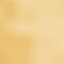

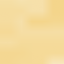

In [15]:
# show one example image
#print(image_data.train[642][1])
image_data.train[1][0]
image_data.test[1][0]

## Tabular data

In [16]:
data.columns

Index(['field1', 'i', 'j', 'lon', 'lat', '습도', '강수', '기온', '풍속', '날씨', '특보내용',
       'target', 'ndvi_img', 'slope_img', 'alt_img', 'forest_img'],
      dtype='object')

In [17]:
dep_var = 'target'
cat_names=['특보내용']
cont_names = ['습도','강수','기온','풍속']
procs = [FillMissing, Categorify, Normalize]

In [18]:
tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dep_var))

# add test
tab_data.add_test(TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names,
                                      processor = tab_data.train.x.processor))

LabelLists;

Train: LabelList (1201 items)
x: TabularList
특보내용 없음; 습도 -0.9616; 강수 -0.0894; 기온 -0.7225; 풍속 0.2050; ,특보내용 없음; 습도 1.0179; 강수 -0.0894; 기온 0.2151; 풍속 -1.1653; ,특보내용 없음; 습도 1.7511; 강수 1.4466; 기온 1.0589; 풍속 -0.7652; ,특보내용 없음; 습도 0.1674; 강수 -0.0894; 기온 -0.6287; 풍속 0.7408; ,특보내용 없음; 습도 1.7665; 강수 4.7334; 기온 -0.5449; 풍속 -0.9333; 
y: CategoryList
0,1,0,0,0
Path: tif_data;

Valid: LabelList (300 items)
x: TabularList
특보내용 없음; 습도 -0.4432; 강수 -0.0894; 기온 -0.7120; 풍속 -0.4556; ,특보내용 없음; 습도 0.2217; 강수 -0.0894; 기온 -0.5775; 풍속 -0.0236; ,특보내용 없음; 습도 0.3682; 강수 -0.0894; 기온 0.0028; 풍속 0.3047; ,특보내용 없음; 습도 -1.4838; 강수 -0.0894; 기온 -0.5613; 풍속 0.1080; ,특보내용 없음; 습도 0.9528; 강수 -0.0894; 기온 0.2634; 풍속 -1.3383; 
y: CategoryList
0,1,0,0,1
Path: tif_data;

Test: LabelList (644 items)
x: TabularList
특보내용 없음; 습도 1.8043; 강수 -0.0894; 기온 1.4611; 풍속 -1.0839; ,특보내용 없음; 습도 -0.1168; 강수 -0.0894; 기온 -0.8381; 풍속 -0.8153; ,특보내용 없음; 습도 -0.1790; 강수 -0.0894; 기온 -0.0385; 풍속 -0.4046; ,특보내용 없음; 습도 0.1956; 강수 -0.0894; 기온

In [19]:
# one example
tab_data.train[0]

(TabularLine [tensor([1]), tensor([-0.9616, -0.0894, -0.7225,  0.2050])],
 Category 0)

## Integrate image and tabular data

In [20]:
integrate_train, integrate_valid, integrate_test = get_imagetabdatasets(image_data, tab_data)

In [21]:
# package train, valid, and test datasets into a fastai databunch
bs = 64

db = DataBunch.create(integrate_train, integrate_valid, integrate_test,
                      path=data_path, bs=bs)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x00000219B9E5D610>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x00000219B9E5D640>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x00000219B9E5D220>

In [22]:
# image normalization with imagenet_stats
db.norm, db.denorm = normalize_funcs_image_tab(*imagenet_stats)
db.add_tfm(db.norm)

In [23]:
# check the shape of one batch
x, y = next(iter(db.train_dl))
len(x)

2

In [24]:
# images
x[0].shape

torch.Size([64, 3, 64, 64])

In [25]:
# categorical and continuous tabular data 
x[1][0].shape, x[1][1].shape

(torch.Size([64, 1]), torch.Size([64, 4]))

In [26]:
# targets
y.shape

torch.Size([64])

## Model that trains on image and tabular data simultaneously

In [27]:
# cnn model for images, use Resnet50 as an example
cnn_arch = models.resnet50

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 256

# use fastai functions to get a cnn model
image_data_db = image_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch, ps=0.2)
cnn_model = cnn_learn.model

C:\Users\user\anaconda3\envs\multimodal\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\multimodal\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# get embedding sizes of categorical data
emb_szs = tab_data.train.get_emb_szs()

# output size of the tabular model that will be concatenated with cnn model output
tab_out_sz = 8

# use fastai functions to get a tabular model
tabular_model = TabularModel(emb_szs, len(cont_names), out_sz=tab_out_sz, layers=[8], ps=0.2)
tabular_model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 2)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [29]:
# get an integrated model that combines the two components and concatenate their outputs
# which will pass through additional fully connected layers
integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=2).to(device)

In [30]:
# check model output dimension, should be (bs, 2)
integrate_model(*x).shape

torch.Size([64, 2])

In [31]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train_df["target"].mean()), 1/train_df["target"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [32]:
# package everything in a fastai learner, add auc roc score as a metric
learn = Learner(db, integrate_model, metrics=[accuracy], loss_func=loss_func)

In [33]:
# organize layer groups in order to use differential learning rates provided by fastai
# the first two layer groups are earlier layers of resnet
# the last layer group consists of the fully connected layers of cnn model, tabular model,
# and final fully connected layers for the concatenated data
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]

## Training

In [34]:
# find learning rate to train the last layer group first 
learn.freeze()
#learn.lr_find()
#learn.recorder.plot()

In [ ]:
# train
learn.fit_one_cycle(5, 1e-4)

In [50]:
# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.620695,0.575430,0.710956,02:03
1,0.611797,0.554637,0.722611,02:06
2,0.596273,0.526393,0.752914,02:02
3,0.586218,0.509649,0.755245,02:02
4,0.567977,0.513634,0.748252,02:02


The model achieved an ROC AUC score of about 0.87 on the validation set.

## Prediction

In [51]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [52]:
preds

tensor([[0.1000, 0.9000],
        [0.2133, 0.7867],
        [0.8872, 0.1128],
        ...,
        [0.7086, 0.2914],
        [0.6039, 0.3961],
        [0.4577, 0.5423]])

In [53]:
preds[:, 1]

tensor([0.9000, 0.7867, 0.1128,  ..., 0.2914, 0.3961, 0.5423])